---
title: "5. My best solution"
image: "disaster.jpeg"
author: "Diegulio"
format: 
  html:
    code-fold: false
jupyter: python3
---

# My Best Solution

In this notebook I will use all the knowledge that we acquiring with the previous notebooks!

In this solution I will be using:

- Transformers
- HuggingFace
- Preprocessing
- Tensorflow
- EarlyStopping

and more..

> Remember that this belong to a NLP Notebook series where I am learning and testing different NLP approachs in this competition. Like NN, Embedding, RNN, Transformers, HuggingFace, etc.

> To see the other notebooks visit: https://www.kaggle.com/code/diegomachado/seqclass-nn-embed-rnn-lstm-gru-bert-hf

## Libraries

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.28.0 which is incompatible.
pytorch-lightning 1.7.7 requires tensorboard>=2.9.1, but you have tensorboard 2.8.0 which is incompatible

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import gc


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Lambda
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow_hub as hub
#import tensorflow_text as text # Bert preprocess uses this 
from tensorflow.keras.optimizers import Adam

import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## HuggingFace Model

In [3]:
# Try with a large model
model_name = "bert-large-uncased"

In [4]:
from transformers import AutoTokenizer

# properly tokenization
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
tokenizer_max_length = 161
def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    return tokenizer(data["text"], truncation=True, padding=True, max_length=tokenizer_max_length)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Data Pre-processing

I will try a preprocessing that I find here:  (I lost the notebook! so sorry, please if someone find it let me know in the comments!)

In [5]:
# Some preprocess 
train = pd.read_csv("/kaggle/input/df-split/df_split/df_train.csv")
test = pd.read_csv("/kaggle/input/df-split/df_split/df_test.csv")


In [6]:
 def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
import spacy
import re
nlp = spacy.load('en_core_web_sm')
def preprocessing(text):
    text = text.replace('#','')
    text = decontracted(text)
    text = re.sub('\S*@\S*\s?','',text)
    text = re.sub('http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)

    #token=[]
    #result=''
    #text = re.sub('[^A-z]', ' ',text.lower())

    #text = nlp(text)
    #for t in text:
    #    if not t.is_stop and len(t)>2:  
    #        token.append(t.lemma_)
    #result = ' '.join([i for i in token])

    return text.strip()

In [8]:
train.text = train.text.apply(lambda x : preprocessing(x)).astype(str)
test.text = test.text.apply(lambda x : preprocessing(x)).astype(str)

In [9]:
# Save processed data to disk
NEW_TRAIN_PATH = "preprocessed_train.csv"
NEW_TEST_PATH = "preprocessed_test.csv"

train.to_csv(NEW_TRAIN_PATH, index = False)
test.to_csv(NEW_TEST_PATH, index = False)

del train
del test
gc.collect()

856

## HF Dataset

In [10]:
# Now We can use HF Datasets
# We need to load our data, for this we use HF datasets
from datasets import load_dataset
data_files = {"train": NEW_TRAIN_PATH,
             "test": NEW_TEST_PATH}
dataset = load_dataset("csv", data_files = data_files, usecols = ['text', 'target'])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fc2dc1866b45d737/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# Tokenization
dataset = dataset.map(tokenize_dataset)

  0%|          | 0/6090 [00:00<?, ?ex/s]

  0%|          | 0/1523 [00:00<?, ?ex/s]

In [12]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [13]:
# we transform the HF dataset into TF dataset
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids","attention_mask"],
    label_cols=["target"],
    batch_size=16,
    collate_fn=data_collator,
    shuffle=True)

tf_val_dataset = test_dataset.to_tf_dataset(
    columns=["input_ids","attention_mask"],
    label_cols=["target"],
    batch_size=16,
    collate_fn=data_collator,
    shuffle=False
    )

## Model

Now we will use restore_best_weights from EarlyStopping

In [14]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

# Load and compile our model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
# Lower learning rates are often better for fine-tuning transformers
model.compile(optimizer=Adam(6e-6),metrics = ['accuracy'])

#checkpoint_filepath = 'checkpoint'
#checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop_callback = EarlyStopping(patience = 5, restore_best_weights = True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=2, min_lr=1e-9)

model.fit(tf_train_dataset,
         validation_data = tf_val_dataset,
          epochs = 20,
          callbacks = [early_stop_callback]
         )

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

2022-12-12 14:19:24.079862: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125018112 exceeds 10% of free system memory.
2022-12-12 14:19:24.239512: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16777216 exceeds 10% of free system memory.
2022-12-12 14:19:24.254974: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16777216 exceeds 10% of free system memory.
2022-12-12 14:19:24.272507: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16777216 exceeds 10% of free system memory.
2022-12-12 14:19:24.294475: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16777216 exceeds 10% of free system memory.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stre

Epoch 1/20
380/380 [==============================] - 164s 344ms/step - loss: 0.4792 - accuracy: 0.7821 - val_loss: 0.4102 - val_accuracy: 0.8286
Epoch 2/20
380/380 [==============================] - 123s 325ms/step - loss: 0.3694 - accuracy: 0.8528 - val_loss: 0.3909 - val_accuracy: 0.8339
Epoch 3/20
380/380 [==============================] - 122s 321ms/step - loss: 0.3145 - accuracy: 0.8832 - val_loss: 0.4103 - val_accuracy: 0.8365
Epoch 4/20
380/380 [==============================] - 122s 322ms/step - loss: 0.2622 - accuracy: 0.9035 - val_loss: 0.4222 - val_accuracy: 0.8391
Epoch 5/20
380/380 [==============================] - 122s 322ms/step - loss: 0.2201 - accuracy: 0.9211 - val_loss: 0.4777 - val_accuracy: 0.8201
Epoch 6/20
380/380 [==============================] - 122s 320ms/step - loss: 0.1804 - accuracy: 0.9327 - val_loss: 0.4962 - val_accuracy: 0.8293
Epoch 7/20
380/380 [==============================] - 123s 323ms/step - loss: 0.1509 - accuracy: 0.9413 - val_loss: 0.5522 -

## Predict Test

In [15]:
pred_dataset = load_dataset("csv", data_files = "/kaggle/input/nlp-getting-started/test.csv", usecols = ['text'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e12e02ba714b9048/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
pred_dataset = pred_dataset.map(tokenize_dataset)

  0%|          | 0/3263 [00:00<?, ?ex/s]

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
tf_pred_dataset = pred_dataset['train'].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    batch_size=16,
    collate_fn=data_collator,
    shuffle=False)

In [18]:
preds = model.predict(tf_pred_dataset)

In [19]:
preds = np.argmax(preds['logits'], axis = 1)

In [20]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_df["target"] = preds

In [21]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [22]:
sub.to_csv("submission.csv", index = False)

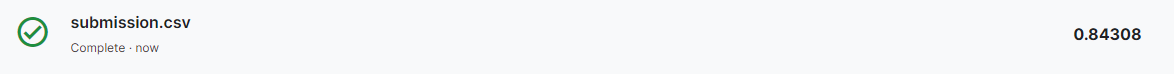

# Conclusions 

Nice! We improve it ! 

Here is a summary of what I use and add:
- I do text pre-process 
- I use A large model from HuggingFace
- I Fine Tune the model `"bert-large-uncased"`
- I decrease the learning rate (I think that it actually was clever!)
- I restore weights in Early Stopping


Nice, I think that was a large and entertainment study journey! We achieve a good score, and furhermore we learnt a lot!
👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏